In [1]:
import os
import numpy as np
from tqdm import tqdm

import torch
from model.dataset import HSEDataset
from torch.utils.data import DataLoader

from model.regressCNN import RegressionPCA
from SMPL.smpl_torch_batch import SMPLModel

from obj_utils.io import *
from obj_utils.pca import *

In [2]:
cuda_available = torch.cuda.is_available()
print('cuda available:', cuda_available)

device = torch.device('cuda:0' if cuda_available else 'cpu')
print('using device', device)

cuda available: True
using device cuda:0


# Inference on Test Set

In [3]:
# pca_base = np.load('./pca_data/train_set_pca_base.npy')
# mean_vertices = np.load('./pca_data/train_set_vertices_mean.npy')

# mesh_faces = np.load('./etc/face.npy')

In [4]:
infer_model_name = 'checkpoint_Mon_May_29_23:14:31_2023'
infer_model_path = f'./checkpoints/{infer_model_name}/male_1000.ckpt'

infer_model = RegressionPCA(10).to(device)
infer_model.load_state_dict(torch.load(infer_model_path))
infer_model.eval()
print('model loaded')

model loaded


In [5]:
test_path = './dataset_HSE/vertex_6890/sample_648/test'

test_dataset = HSEDataset(test_path, predict_only=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=256)

loading data: 100%|██████████| 170/170 [00:00<00:00, 1259.62it/s]


In [6]:
def infer(frontal, lateral):
    with torch.no_grad():
        result = infer_model(frontal, lateral)
    
    return result

In [7]:
smpl_model_path = './SMPL/model.pkl'
smpl_model = SMPLModel(device=torch.device('cuda'), model_path=smpl_model_path)

 Tensor J_regressor shape:  torch.Size([24, 6890])
 Tensor joint_regressor shape:  torch.Size([24, 6890])
 Tensor weights shape:  torch.Size([6890, 24])
 Tensor posedirs shape:  torch.Size([6890, 3, 207])
 Tensor v_template shape:  torch.Size([6890, 3])
 Tensor shapedirs shape:  torch.Size([6890, 3, 10])


In [8]:
obj_path = './dataset_HSE/vertex_6890/obj/test'
result_path = f'./test_results/{infer_model_name}'

In [9]:
name_list = []
result_list = []

for data in tqdm(test_dataloader):
    names, f, l, s = data
    name_list.extend(names)

    f = f.to(device, dtype=torch.float)
    l = l.to(device, dtype=torch.float)
    result = infer(f, l)
    result = np.array(result.to('cpu'))
    result_list.append(result)

result_arr = np.vstack(result_list)
print(result_arr.shape)

100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

(170, 10)


In [20]:
pose = torch.from_numpy(np.zeros((result_arr.shape[0], 72))).type(torch.float64).to(device)
pose[:,16 *3 +2] = -np.pi / 4
pose[:,17 *3 +2] = np.pi / 4
beta = torch.from_numpy(result_arr).type(torch.float64).to(device)
trans = torch.from_numpy(np.zeros((result_arr.shape[0], 3))).type(torch.float64).to(device)

In [25]:
v_outs, _ = smpl_model(beta, pose, trans)
v_outs = v_outs.cpu()
v_outs.shape

torch.Size([170, 6890, 3])

In [26]:
for name, v_out in tqdm(zip(name_list, v_outs), total=len(v_outs)):
    v_gt, faces = load_obj(os.path.join(obj_path, name+'.obj'))
    # v_y_gt = v_gt[:, 1]
    # height_gt = max(v_y_gt) - min(v_y_gt)

    # v_out = shape_parameter_to_vertices(result, mean_vertices, pca_base, scale=True, height=height_gt)
    
    save_path = os.path.join(result_path, name)
    os.makedirs(save_path, exist_ok=True)
    save_obj(os.path.join(save_path, 'mesh_gt.obj'), v_gt, faces)
    save_obj(os.path.join(save_path, 'mesh_out.obj'), v_out, faces)

100%|██████████| 170/170 [00:32<00:00,  5.24it/s]


# Calculate V2V

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from trimesh.registration import icp

from obj_utils.io import *
from obj_utils.transform import *
from obj_utils.misc import *

In [30]:
model_name = 'checkpoint_Mon_May_29_23:14:31_2023'
result_path = f'./test_results/{model_name}'
name_list = [i for i in os.listdir(result_path) if i.startswith('smpl')]

In [31]:
green, red = np.array([0., 1., 0.]), np.array([1., 0., 0.])
v2v_list = []

for name in tqdm(name_list):
    v_gt, _ = load_obj(os.path.join(result_path, name, 'mesh_gt.obj'))
    v_out, _ = load_obj(os.path.join(result_path, name, 'mesh_out.obj'))

    v_gt_trans = move_to_center_position(v_gt)
    v_out_trans = move_to_center_position(v_out)
    _, v_out_trans, _ = icp(v_out_trans, v_gt_trans, scale=False)
    
    diff = v_gt_trans - v_out_trans
    v2v = np.linalg.norm(diff, axis=1).mean()
    v2v_list.append(v2v)

    v_gt_colored = add_vertices_color(v_gt_trans, green)
    v_out_trans_colored = add_vertices_color(v_out_trans, red)

    v_merged = merge_vertices(v_gt_colored, v_out_trans_colored)
    save_obj(os.path.join(result_path, name, 'mesh_merged.obj'), v_merged, None)

v2v_arr = np.array(v2v_list) * 1000 # m -> mm
np.save(os.path.join(result_path, 'v2v_arr.npy'), v2v_arr)

100%|██████████| 170/170 [00:47<00:00,  3.58it/s]


mean, std = 1.770 mm, 0.929 mm
min, max = 0.532 mm, 8.586 mm


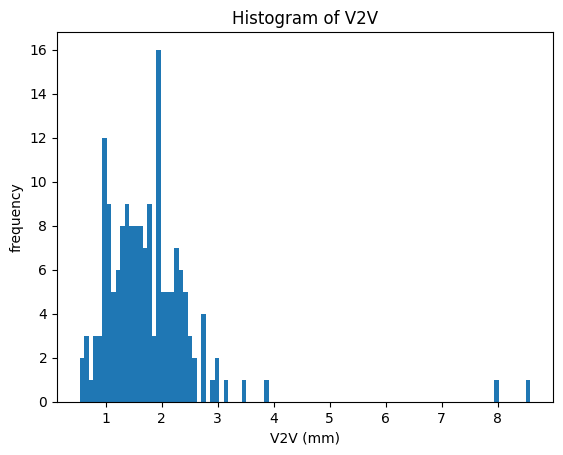

In [32]:
v2v_arr = np.load(os.path.join(result_path, 'v2v_arr.npy'))

print(f'mean, std = {v2v_arr.mean():.3f} mm, {v2v_arr.std():.3f} mm')
print(f'min, max = {v2v_arr.min():.3f} mm, {v2v_arr.max():.3f} mm')

hist, bins = np.histogram(v2v_arr, bins=100)

plt.title('Histogram of V2V')
plt.xlabel('V2V (mm)')
plt.ylabel('frequency')

plt.hist(bins[:-1], bins, weights=hist)
plt.show()

In [25]:
idx = np.where(v2v_arr > 20)[0]

for i in idx:
    print(name_list[i])

caesar_3177
caesar_3729
